Маски Байеровского шаблона для трех каналов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rgb_mask(greyscale_image):
    rgb_mask_snippet = np.array([
        [[0, 1, 0], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
    ]) 
    n_rows = greyscale_image.shape[0]
    n_cols = greyscale_image.shape[1]
    
    rgb_mask = np.tile(rgb_mask_snippet, (n_rows // 2, n_cols // 2, 1))
    rgb_mask = rgb_mask[:n_rows, :n_cols, :]
    return rgb_mask

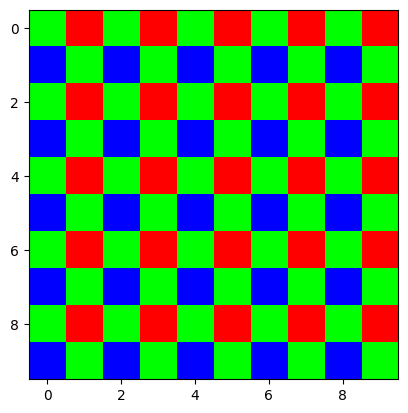

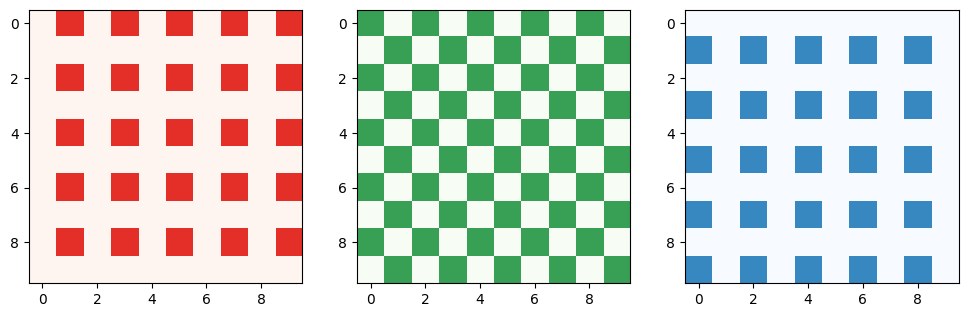

In [3]:
zeros_image = np.zeros((10,10))
plt.imshow(rgb_mask(zeros_image)*255)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(rgb_mask(zeros_image)[:,:,0], cmap='Reds', vmax=1.5)
ax[1].imshow(rgb_mask(zeros_image)[:,:,1], cmap='Greens', vmax=1.5)
ax[2].imshow(rgb_mask(zeros_image)[:,:,2], cmap='Blues', vmax=1.5)

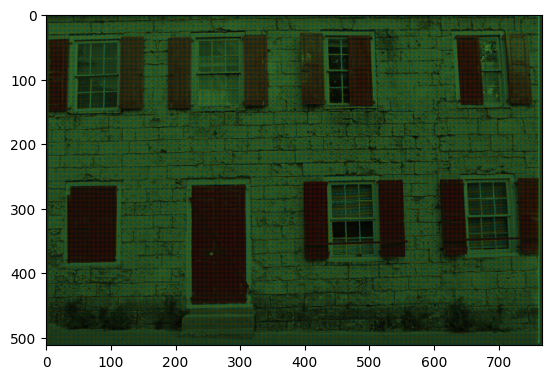

In [4]:
from skimage.io import imread

def greyscale_to_rgb_shit(greyscale_image):
    rgb_masked = rgb_mask(greyscale_image)
    return rgb_masked * greyscale_image[:, :, np.newaxis]

img_1 = imread('./images/01.png')
plt.imshow(greyscale_to_rgb_shit(img_1))


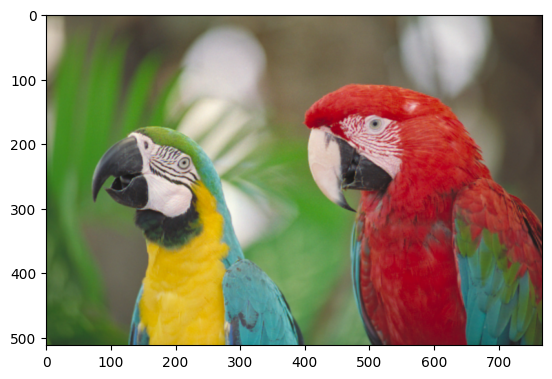

In [5]:
from scipy.signal import convolve2d
from skimage.io import imread
import cv2

def rgb_mask(greyscale_image):
    rgb_mask_snippet = np.array([
        [[0, 1, 0], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
    ]) 
    n_rows = greyscale_image.shape[0]
    n_cols = greyscale_image.shape[1]
    
    rgb_mask = np.tile(rgb_mask_snippet, (n_rows // 2, n_cols // 2, 1))
    rgb_mask = rgb_mask[:n_rows, :n_cols, :]
    return rgb_mask

def greyscale_to_rgb_shit(greyscale_image):
    rgb_masked = rgb_mask(greyscale_image)
    return rgb_masked * greyscale_image[:, :, np.newaxis]

def bilinear_interpolation(greyscale_image):
    sum_kernel = np.ones((3, 3))
    rgb_masked = rgb_mask(greyscale_image).astype(np.float32)
    colored_image = greyscale_to_rgb_shit(greyscale_image).astype(np.float32)
    colored_image += cv2.filter2D(colored_image, -1, sum_kernel) / cv2.filter2D(rgb_masked, -1, sum_kernel) * ~(rgb_masked.astype(bool))
    return (colored_image).astype(int)

img_1 = imread('./images/09.png')
plt.imshow(bilinear_interpolation(img_1) / 255)

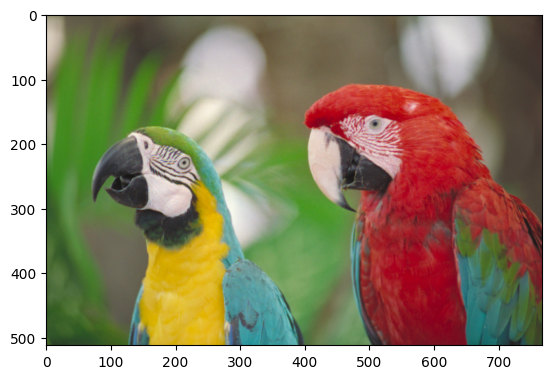

In [6]:
def rgb_mask(greyscale_image):
    rgb_mask_snippet = np.array([
        [[0, 1, 0], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
    ]) 
    n_rows = greyscale_image.shape[0]
    n_cols = greyscale_image.shape[1]
    
    rgb_mask = np.tile(rgb_mask_snippet, (n_rows // 2, n_cols // 2, 1))
    rgb_mask = rgb_mask[:n_rows, :n_cols, :]
    return rgb_mask

def even_row_column_mask(greyscale_image):
    n_rows = greyscale_image.shape[0]
    n_cols = greyscale_image.shape[1]
    odd_row_mask = np.tile(np.array([[0], [1]]), (n_rows//2, n_cols))[:n_rows, :n_cols].astype(bool)
    odd_col_mask = np.tile(np.array([[0, 1]]), (n_rows, n_cols//2))[:n_rows, :n_cols].astype(bool)
    return odd_row_mask, odd_col_mask

def greyscale_to_rgb_shit(greyscale_image):
    rgb_masked = rgb_mask(greyscale_image)
    return rgb_masked * greyscale_image[:, :, np.newaxis]

def better_interpolation(greyscale_image):
    G_at_R = G_at_B = np.array([
        [0, 0, -1, 0, 0],
        [0, 0, 2, 0, 0],
        [-1, 2, 4, 2, -1],
        [0, 0, 2, 0, 0],
        [0, 0, -1, 0, 0]
    ]) / 8

    R_at_G_in_R = B_at_G_in_B = np.array([
        [0, 0, .5, 0, 0],
        [0, -1, 0, -1, 0],
        [-1, 4, 5, 4, -1],
        [0, -1, 0, -1, 0],
        [0, 0, .5, 0, 0]
    ]) / 8

    R_at_G_in_B = B_at_G_in_R = R_at_G_in_R.T

    R_at_B_in_B = B_at_R_in_R = np.array([
        [0, 0, -1.5, 0, 0],
        [0, 2, 0, 2, 0],
        [-1.5, 0, 6, 0, -1.5],
        [0, 2, 0, 2, 0],
        [0, 0, -1.5, 0, 0]
    ]) / 8

    rgb_masked = rgb_mask(greyscale_image).astype(bool)
    even_row, even_col = even_row_column_mask(greyscale_image)
    sparse_image = greyscale_to_rgb_shit(greyscale_image).astype(np.float32)
    colored_image = sparse_image.copy()
    colored_image += ~rgb_masked[:, :, 1][:, :, None] * cv2.filter2D(sparse_image, -1, G_at_R) * [0, 1, 0]

    colored_image += (~rgb_masked[:, :, 0] * ~even_row)[:, :, None] * cv2.filter2D(sparse_image, -1, R_at_G_in_R) * [1, 0, 0]
    colored_image += (~rgb_masked[:, :, 0] * (even_row * even_col))[:, :, None] * cv2.filter2D(sparse_image, -1, R_at_G_in_B) * [1, 0, 0]
    colored_image += (~rgb_masked[:, :, 0] * (even_row * ~even_col))[:, :, None] * cv2.filter2D(sparse_image, -1, R_at_B_in_B) * [1, 0, 0]

    colored_image += (~rgb_masked[:, :, 2] * even_row)[:, :, None] * cv2.filter2D(sparse_image, -1, B_at_G_in_B) * [0, 0, 1]
    colored_image += (~rgb_masked[:, :, 2] * (~even_row * ~even_col))[:, :, None] * cv2.filter2D(sparse_image, -1, B_at_G_in_R) * [0, 0, 1]
    colored_image += (~rgb_masked[:, :, 2] * (~even_row * even_col))[:, :, None] * cv2.filter2D(sparse_image, -1, B_at_R_in_R) * [0, 0, 1]

    return colored_image.astype(np.uint8)


img_1 = imread('./images/09.png')
plt.imshow(better_interpolation(img_1))
